In [1]:
import pandas as pd

# Load the CSV
file_path = r"D:\Portfolio projects\pricing analyst.csv"   # change path if needed
df = pd.read_csv(file_path)

# Quick check
print("Shape:", df.shape)
print(df.head())
print(df.info())


Shape: (676, 30)
  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01/05/2017    1        45.95   
1       bed1        bed_bath_table  01/06/2017    3       137.85   
2       bed1        bed_bath_table  01/07/2017    6       275.70   
3       bed1        bed_bath_table  01/08/2017    4       183.80   
4       bed1        bed_bath_table  01/09/2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0               

In [2]:
# === Step 2: Split into Products Table and Facts Table ===

# Products table = product attributes (don’t change over time)
product_cols = [
    "product_id",
    "product_category_name",
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty",
    "product_weight_g",
    "product_score"
]
products = df[product_cols].drop_duplicates().reset_index(drop=True)

# Facts table = time-varying data (changes each month)
fact_cols = [
    "product_id",
    "month_year",
    "qty",
    "unit_price",
    "total_price",
    "freight_price",
    "lag_price",
    "customers",
    "volume",
    "comp_1","comp_2","comp_3",
    "ps1","ps2","ps3",
    "fp1","fp2","fp3",
    "weekday","weekend","holiday","month","year"
]
facts = df[fact_cols].copy()

# Save both tables
products.to_csv(r"D:\Portfolio projects\products_table.csv", index=False)
facts.to_csv(r"D:\Portfolio projects\facts_table.csv", index=False)

# Quick preview
print("Products table shape:", products.shape)
print(products.head())
print("\nFacts table shape:", facts.shape)
print(facts.head())


Products table shape: (52, 7)
  product_id product_category_name  product_name_lenght  \
0       bed1        bed_bath_table                   39   
1    garden5          garden_tools                   36   
2  consoles1        consoles_games                   49   
3    garden7          garden_tools                   57   
4    health9         health_beauty                   48   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                         161                   2               350   
1                         450                   1              9000   
2                         100                   4               150   
3                         339                   2              1800   
4                         575                   1               100   

   product_score  
0            4.0  
1            4.1  
2            4.2  
3            4.2  
4            4.3  

Facts table shape: (676, 23)
  product_id  month_year  qty  unit_price  t

In [3]:
import pandas as pd

# 1) Load the split tables
products = pd.read_csv(r"D:\Portfolio projects\products_table.csv")
facts = pd.read_csv(r"D:\Portfolio projects\facts_table.csv")

# 2) Join on product_id
df_joined = facts.merge(
    products[["product_id","product_category_name","product_weight_g","product_score"]],
    on="product_id",
    how="left"
)

# 3) Basic validation checks

# Missing values count
missing_summary = df_joined.isna().sum()

# Duplicates check (same product_id + month_year)
dup_count = df_joined.duplicated(subset=["product_id","month_year"]).sum()

# Range checks (negative prices or quantities)
neg_qty = (df_joined["qty"] < 0).sum()
neg_price = (df_joined["unit_price"] <= 0).sum()

# Time coverage check
df_joined["month_year"] = pd.to_datetime(df_joined["month_year"], dayfirst=True, errors="coerce")
time_coverage = df_joined["month_year"].min(), df_joined["month_year"].max()

# Print summary
print("Missing values per column:\n", missing_summary)
print("\nDuplicate product-month rows:", dup_count)
print("\nNegative qty count:", neg_qty)
print("Zero/negative price count:", neg_price)
print("\nDate coverage:", time_coverage)

# 4) Save the joined file
df_joined.to_csv(r"D:\Portfolio projects\pricing_joined.csv", index=False)

Missing values per column:
 product_id               0
month_year               0
qty                      0
unit_price               0
total_price              0
freight_price            0
lag_price                0
customers                0
volume                   0
comp_1                   0
comp_2                   0
comp_3                   0
ps1                      0
ps2                      0
ps3                      0
fp1                      0
fp2                      0
fp3                      0
weekday                  0
weekend                  0
holiday                  0
month                    0
year                     0
product_category_name    0
product_weight_g         0
product_score            0
dtype: int64

Duplicate product-month rows: 0

Negative qty count: 0
Zero/negative price count: 0

Date coverage: (Timestamp('2017-01-01 00:00:00'), Timestamp('2018-08-01 00:00:00'))


In [17]:
import numpy as np

df = pd.read_csv(r"D:\Portfolio projects\pricing_joined.csv")

# 1) Sudden price jumps
df["price_jump_abs"] = (df["unit_price"] - df["lag_price"]).abs()
df["price_jump_flag"] = (df["lag_price"] > 0) & ((df["price_jump_abs"] / df["lag_price"]) > 0.20)

# 2) Competitor index (our price ÷ competitor)
for c in ["comp_1","comp_2","comp_3"]:
    if c in df.columns:
        df[f"index_vs_{c}"] = df["unit_price"] / df[c]
        df[f"high_vs_{c}"] = df[f"index_vs_{c}"] > 1.05  # >5% above competitor

# 3) Exceptions queue = rows needing human review
flags = df["price_jump_flag"]
for c in ["high_vs_comp_1","high_vs_comp_2","high_vs_comp_3"]:
    if c in df.columns:
        flags = flags | df[c]

exceptions = df.loc[flags, [
    "product_id","product_category_name","month_year","unit_price","lag_price",
    "comp_1","comp_2","comp_3","price_jump_abs","price_jump_flag"
] + [col for col in df.columns if col.startswith("index_vs_")]].copy()

# Rank exceptions: price jumps first, then worst competitor gap
def worst_gap(row):
    gaps = []
    for c in ["index_vs_comp_1","index_vs_comp_2","index_vs_comp_3"]:
        if c in row and pd.notna(row[c]):
            gaps.append(row[c] - 1.0)
    return max(gaps) if gaps else np.nan

exceptions["worst_index_gap"] = exceptions.apply(worst_gap, axis=1)
exceptions = exceptions.sort_values(["price_jump_flag","worst_index_gap"], ascending=[False, False])
exceptions["rank"] = range(1, len(exceptions)+1)

# Save for BI
exceptions.to_csv(r"D:\Portfolio projects\exceptions_queue.csv", index=False)

print("Exceptions queue saved. Sample:")
print(exceptions.head(10))


Exceptions queue saved. Sample:
     product_id  product_category_name  month_year  unit_price   lag_price  \
504  furniture2        furniture_decor  2018-06-01   89.900000   69.900000   
560     garden1           garden_tools  2018-01-01  127.727273   89.990000   
430     garden3           garden_tools  2018-01-01  123.331667   89.990000   
377  furniture4        furniture_decor  2018-07-01   78.535714   99.900000   
640    watches1          watches_gifts  2017-10-01  232.490000  164.570000   
641    watches1          watches_gifts  2017-11-01  174.433333  232.490000   
612    watches7          watches_gifts  2018-07-01  169.349318  245.900000   
328  computers1  computers_accessories  2018-08-01   79.900000   66.342143   
286       cool3             cool_stuff  2018-06-01   65.000000   35.000000   
336   consoles2         consoles_games  2018-02-01   32.500000   27.033333   

         comp_1  comp_2      comp_3  price_jump_abs  price_jump_flag  \
504   89.900000   35.00   99.900000  

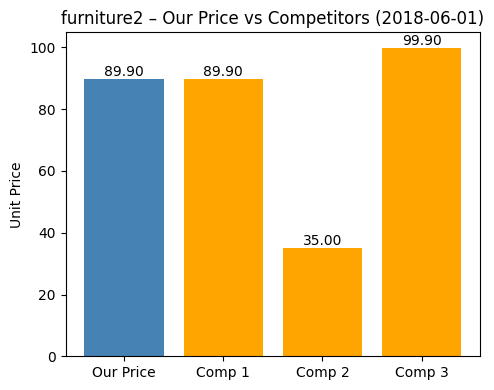

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

exc = pd.read_csv(r"D:\Portfolio projects\exceptions_queue.csv")
row = exc.iloc[0]

labels = ["Our Price", "Comp 1", "Comp 2", "Comp 3"]
values = [row["unit_price"], row["comp_1"], row["comp_2"], row["comp_3"]]

plt.figure(figsize=(5,4))
bars = plt.bar(labels, values, color=["steelblue","orange","orange","orange"])
plt.title(f"{row['product_id']} – Our Price vs Competitors ({row['month_year']})")
plt.ylabel("Unit Price")
for b in bars:
    y = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, y, f"{y:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


Chosen category: garden_tools
Monthly points: 19


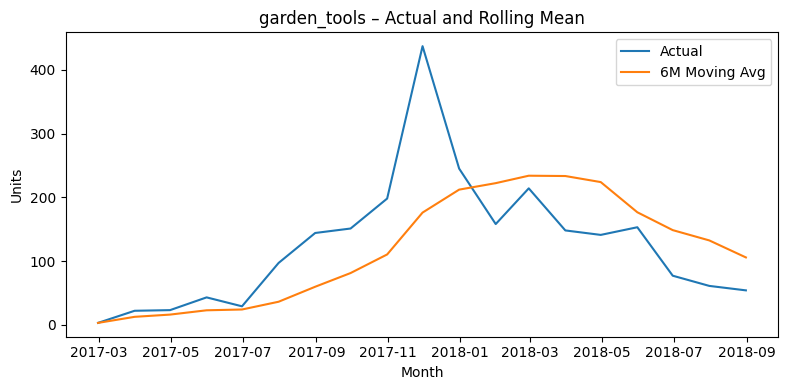

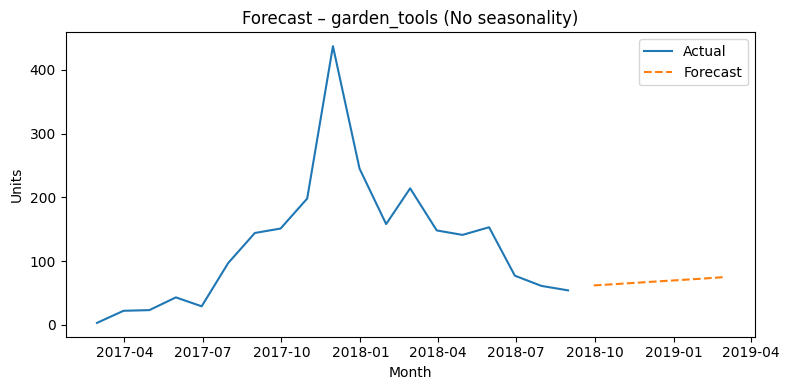

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- LOAD ---
df = pd.read_csv(r"D:\Portfolio projects\pricing analyst.csv")

# Parse dates safely
df["month_year"] = pd.to_datetime(df["month_year"], dayfirst=True, errors="coerce")

# Keep reasonable rows
df = df.dropna(subset=["month_year", "product_category_name", "qty"])
df["qty"] = pd.to_numeric(df["qty"], errors="coerce").fillna(0)

# --- BUILD monthly series per category ---
cat_month = (
    df.groupby(["product_category_name", pd.Grouper(key="month_year", freq="M")])["qty"]
      .sum()
      .reset_index()
)

# Pick the best category automatically: longest monthly span with >=24 points
candidates = []
for cat, g in cat_month.groupby("product_category_name"):
    g = g.sort_values("month_year")
    n = g["qty"].count()
    if n >= 24:
        span = (g["month_year"].max() - g["month_year"].min()).days
        candidates.append((cat, n, span))
        
if candidates:
    # choose the one with most points, break ties by largest span
    candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
    chosen = candidates[0][0]
else:
    # fallback: top category by total qty (even if <24)
    chosen = (cat_month.groupby("product_category_name")["qty"].sum()
                        .sort_values(ascending=False).index[0])

sub = cat_month[cat_month["product_category_name"] == chosen].copy()
sub = sub.sort_values("month_year").set_index("month_year")["qty"].asfreq("M").fillna(0)

print(f"Chosen category: {chosen}")
print(f"Monthly points: {len(sub)}")

# --- TRY full seasonal decomposition if enough data ---
def plot_decompose(series):
    result = seasonal_decompose(series, model="additive", period=12, extrapolate_trend="freq")
    result.plot()
    plt.suptitle(f"Decomposition – {chosen}", y=1.02)
    plt.show()

def plot_forecast(series, seasonal=True):
    if seasonal and len(series) >= 24:
        model = ExponentialSmoothing(series, trend="add", seasonal="add", seasonal_periods=12)
    else:
        # fallback: no seasonality
        model = ExponentialSmoothing(series, trend="add", seasonal=None)
    fit = model.fit(optimized=True, use_brute=True)
    fc = fit.forecast(6)

    plt.figure(figsize=(8,4))
    plt.plot(series.index, series.values, label="Actual")
    plt.plot(fc.index, fc.values, "--", label="Forecast")
    ttl = f"Forecast – {chosen} ({'Seasonal' if seasonal and len(series)>=24 else 'No seasonality'})"
    plt.title(ttl)
    plt.xlabel("Month"); plt.ylabel("Units")
    plt.legend()
    plt.tight_layout()
    plt.show()

if len(sub) >= 24:
    # Full seasonal path
    plot_decompose(sub)
    plot_forecast(sub, seasonal=True)
else:
    # Fallback visuals: rolling mean + non-seasonal forecast
    plt.figure(figsize=(8,4))
    plt.plot(sub.index, sub.values, label="Actual")
    if len(sub) >= 6:
        plt.plot(sub.rolling(6, min_periods=1).mean(), label="6M Moving Avg")
    plt.title(f"{chosen} – Actual and Rolling Mean")
    plt.xlabel("Month"); plt.ylabel("Units"); plt.legend()
    plt.tight_layout(); plt.show()

    plot_forecast(sub, seasonal=False)


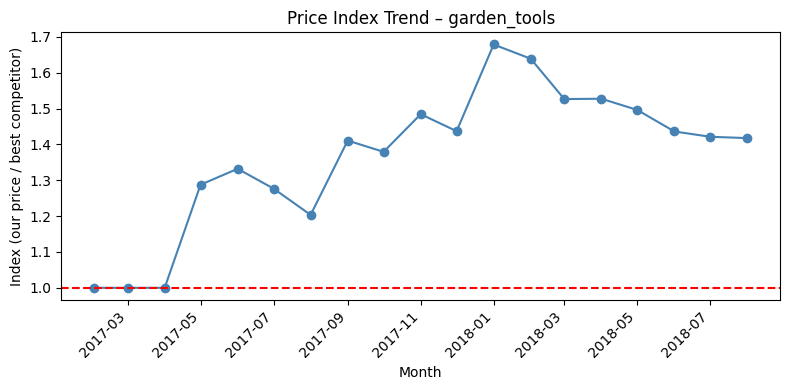

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv(r"D:\Portfolio projects\pricing analyst.csv")

# Convert dates
df["month_year"] = pd.to_datetime(df["month_year"], dayfirst=True, errors="coerce")

# Clean numeric columns
for c in ["unit_price","comp_1","comp_2","comp_3"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Calculate best competitor price and index
df["best_comp_price"] = df[["comp_1","comp_2","comp_3"]].min(axis=1, skipna=True)
df["index_vs_best"] = df["unit_price"] / df["best_comp_price"]

# Aggregate at category × month level
cat = "garden_tools"  # choose a category
trend = (
    df[df["product_category_name"]==cat]
    .groupby("month_year")["index_vs_best"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(8,4))
plt.plot(trend["month_year"], trend["index_vs_best"], marker="o", color="steelblue")
plt.axhline(1.0, color="red", linestyle="--")
plt.title(f"Price Index Trend – {cat}")
plt.xlabel("Month")
plt.ylabel("Index (our price / best competitor)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


SKU chosen: bed5
Units by period:
 period
Before    52.0
During    32.0
After      NaN
Name: qty, dtype: float64
GM€ by period:
 period
Before    8582.459803
During    4125.958710
After             NaN
Name: gm€, dtype: float64


ValueError: cannot convert float NaN to integer

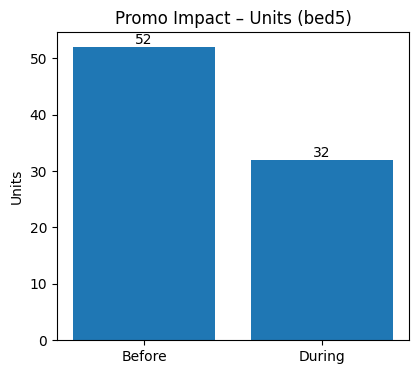

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
df = pd.read_csv(r"D:\Portfolio projects\pricing analyst.csv")
df["month_year"] = pd.to_datetime(df["month_year"], dayfirst=True, errors="coerce")

# Numeric
for c in ["qty","unit_price","lag_price","comp_1","comp_2","comp_3"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 1) Infer promo months: price drop >=15% vs last month
df["promo_flag"] = (df["lag_price"] > 0) & (df["unit_price"] < 0.85 * df["lag_price"])

# 2) Pick a SKU that has a promo month
promo_skus = df.groupby("product_id")["promo_flag"].sum()
sku = promo_skus[promo_skus > 0].index[0]  # first SKU with a promo-like drop
sub = df[df["product_id"] == sku].sort_values("month_year").copy()

# 3) Define periods: Before, During, After (relative to first promo month)
promo_months = sub.loc[sub["promo_flag"], "month_year"].sort_values().unique()
first_promo = promo_months[0]

sub["period"] = "Other"
sub.loc[sub["month_year"] == first_promo, "period"] = "During"
sub.loc[sub["month_year"] == (first_promo - pd.offsets.MonthBegin(1)), "period"] = "Before"
sub.loc[sub["month_year"] == (first_promo + pd.offsets.MonthBegin(1)), "period"] = "After"

# 4) Build margin proxy and aggregate
sub["best_comp_price"] = sub[["comp_1","comp_2","comp_3"]].min(axis=1, skipna=True)
sub["unit_cost_proxy"] = 0.75 * sub["best_comp_price"]
sub["gm€"] = (sub["unit_price"] - sub["unit_cost_proxy"]) * sub["qty"]

agg_units = sub[sub["period"].isin(["Before","During","After"])].groupby("period")["qty"].sum().reindex(["Before","During","After"])
agg_gm    = sub[sub["period"].isin(["Before","During","After"])].groupby("period")["gm€"].sum().reindex(["Before","During","After"])

print(f"SKU chosen: {sku}")
print("Units by period:\n", agg_units)
print("GM€ by period:\n", agg_gm)

# 5) Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bars = plt.bar(agg_units.index, agg_units.values)
plt.title(f"Promo Impact – Units ({sku})"); plt.ylabel("Units")
for b in bars:
    y=b.get_height(); plt.text(b.get_x()+b.get_width()/2, y, int(y), ha="center", va="bottom")

plt.subplot(1,2,2)
bars = plt.bar(agg_gm.index, agg_gm.values)
plt.title("Promo Impact – Gross Margin € (proxy)"); plt.ylabel("€")
for b in bars:
    y=b.get_height(); plt.text(b.get_x()+b.get_width()/2, y, f"{y:,.0f}", ha="center", va="bottom")

plt.tight_layout(); plt.show()
